# Plant Disease Classification – Data Preprocessing

This notebook performs the complete preprocessing pipeline for plant disease
image classification.

It includes:
- Image transformations (train & validation)
- Dataset loading with automatic label assignment
- DataLoader creation
- Class imbalance handling
- Sanity checks
- Visualization of batches and augmentations

This notebook **does NOT include model training**.


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter
from PIL import Image


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## ImageNet Normalization

Pretrained CNN models expect inputs normalized using ImageNet statistics.

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

## Training Transforms

Operations applied **on-the-fly** during training:
- Resize to 224×224
- Random flips
- Random rotation
- Color jitter
- Convert to tensor
- Normalize using ImageNet statistics

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

## Validation Transforms

No augmentation is applied to validation data.

In [5]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

## Load Dataset Using ImageFolder

- Images are loaded from folder structure
- Labels are automatically assigned from folder names
- Transforms are applied on-the-fly


In [6]:
train_path = r"C:\Users\USER\Desktop\plant_disease\dataset\images\train"
val_path   = r"C:\Users\USER\Desktop\plant_disease\dataset\images\val"


train_dataset = datasets.ImageFolder(
    root=train_path,
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=val_path,
    transform=val_transforms
)

class_names = train_dataset.classes
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("Class names:", class_names)


Number of classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotte

## Verify Dataset Integrity


In [7]:
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Class to index mapping:", train_dataset.class_to_idx)

if train_dataset.classes == val_dataset.classes:
    print("Train and validation datasets have identical class structure")
else:
    print("Class mismatch between train and validation datasets")


Train samples: 43444
Val samples: 10861
Class to index mapping: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 

## Create DataLoaders

Configuration:
- Batch size = 32
- Train: shuffle = True
- Validation: shuffle = False
- num_workers = 2
- pin_memory = True


In [8]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("Train loader:", len(train_loader), "batches")
print("Val loader:", len(val_loader), "batches")


Train loader: 1358 batches
Val loader: 340 batches


## Handle Class Imbalance

Class imbalance is handled using **weighted CrossEntropyLoss**.


In [9]:
train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)

total_samples = sum(class_counts.values())

class_weights = [
    total_samples / class_counts[i]
    for i in range(num_classes)
]

class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)


Class weights: tensor([ 86.1984,  87.5887, 197.4727,  33.0122,  36.1431,  51.5962,  63.5146,
        105.9610,  45.5866,  55.1320,  46.7643,  46.0212,  39.2448,  50.4576,
        128.1534,   9.8624,  23.6366, 150.8472,  54.5094,  36.7236,  54.3050,
         54.3050, 359.0413, 146.2761,  10.6690,  29.5940,  48.9786, 119.3516,
         25.5253,  54.3050,  28.4506,  57.0880,  30.6591,  32.3967,  38.6857,
         10.1363, 145.2977,  34.1273])


## Verify Preprocessing Pipeline


In [10]:
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))

print("TRAIN BATCH")
print("Images shape:", train_images.shape)
print("Labels shape:", train_labels.shape)
print("Dtype:", train_images.dtype)
print("Value range:", train_images.min().item(), train_images.max().item())

print("\nVAL BATCH")
print("Images shape:", val_images.shape)
print("Labels shape:", val_labels.shape)
print("Value range:", val_images.min().item(), val_images.max().item())


c:\Users\USER\Desktop\plant_disease\venv\lib\site-packages\torch\utils\data\dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


TRAIN BATCH
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Dtype: torch.float32
Value range: -2.1179039478302 2.640000104904175

VAL BATCH
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Value range: -2.1007792949676514 2.640000104904175


## Denormalization (for Visualization Only)


In [11]:
def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)


## Visualize Data Augmentation Effects


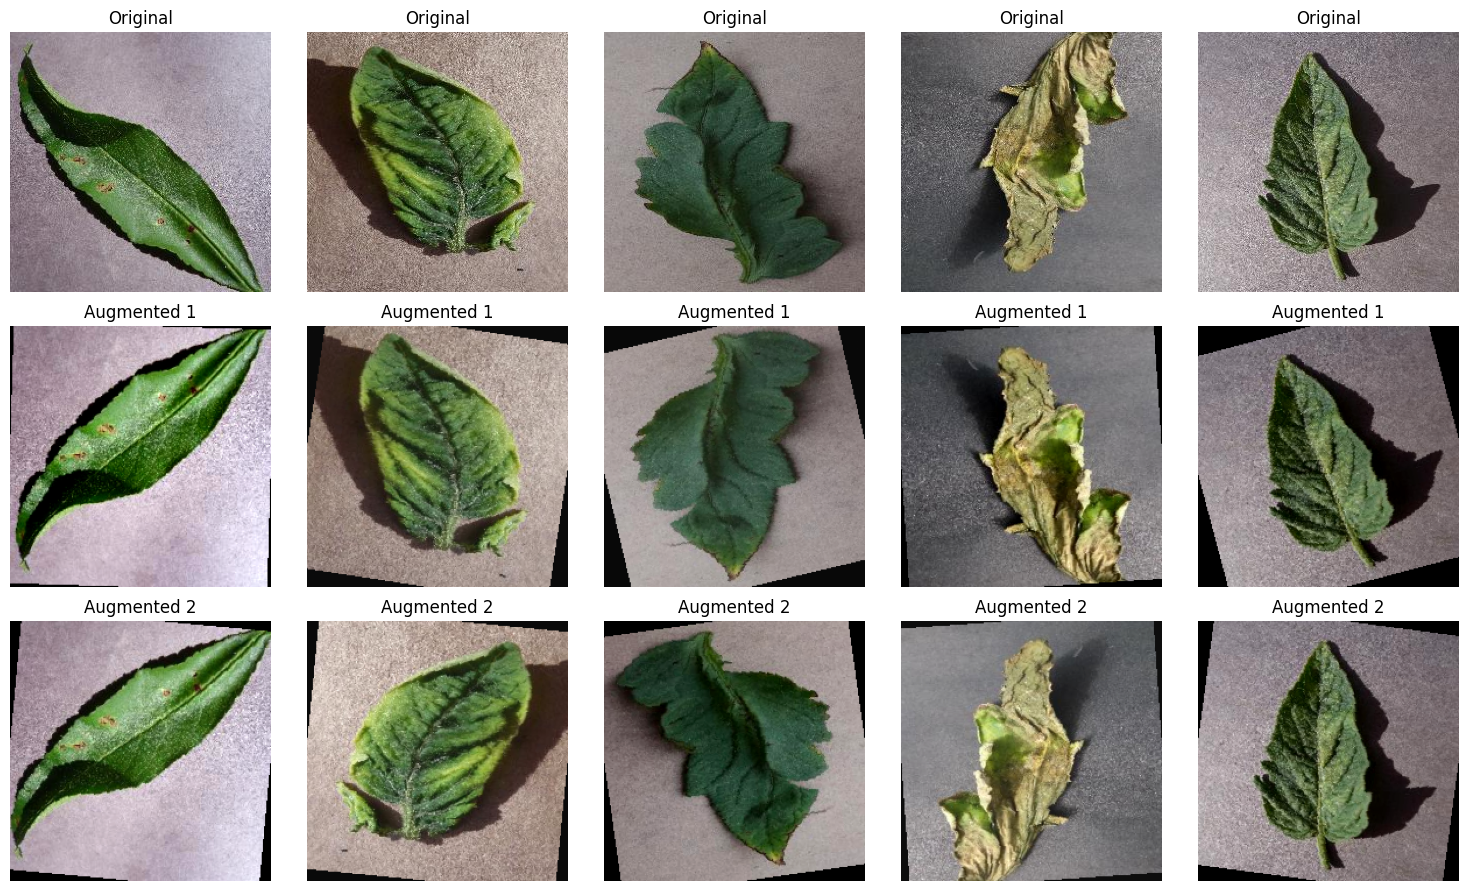

In [12]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

np.random.seed(42)
indices = np.random.choice(len(train_dataset), 5, replace=False)

for col, idx in enumerate(indices):
    img_path, _ = train_dataset.samples[idx]
    original = Image.open(img_path)

    axes[0, col].imshow(original)
    axes[0, col].set_title("Original")
    axes[0, col].axis("off")

    aug1 = denormalize(train_transforms(original).clone()).permute(1, 2, 0)
    axes[1, col].imshow(aug1)
    axes[1, col].set_title("Augmented 1")
    axes[1, col].axis("off")

    aug2 = denormalize(train_transforms(original).clone()).permute(1, 2, 0)
    axes[2, col].imshow(aug2)
    axes[2, col].set_title("Augmented 2")
    axes[2, col].axis("off")

plt.tight_layout()
plt.show()


## Visualize Sample Batches from Train and Validation Loaders


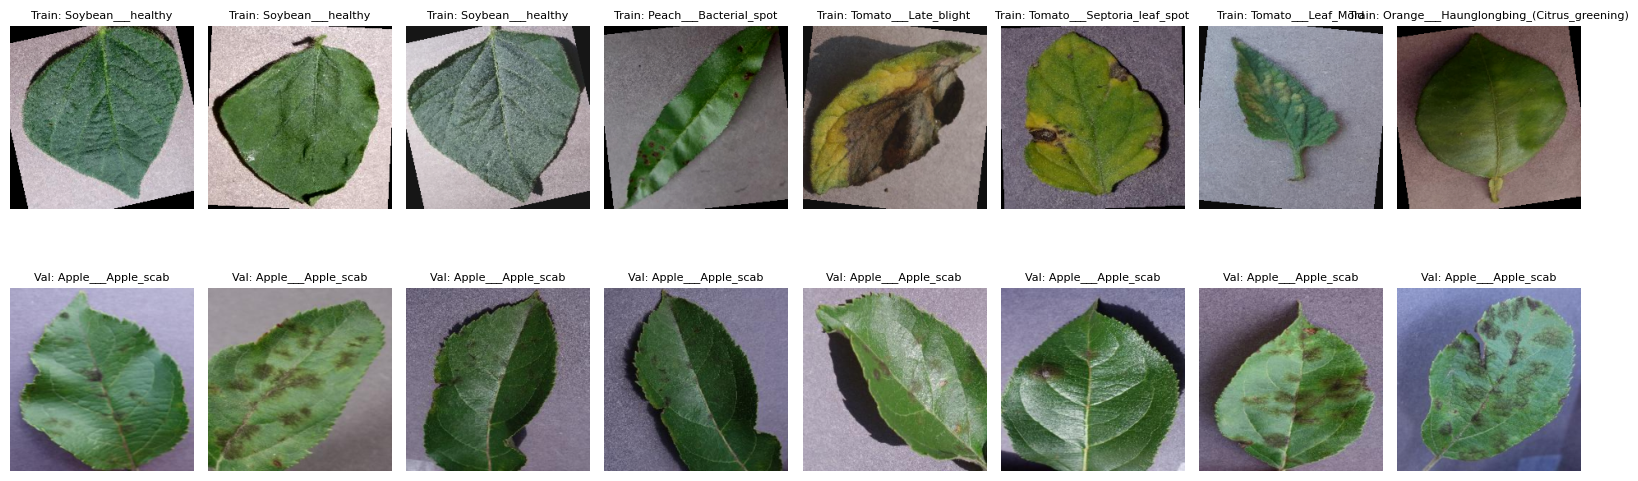

In [13]:
fig, axes = plt.subplots(2, 8, figsize=(16, 6))

train_imgs, train_lbls = next(iter(train_loader))
val_imgs, val_lbls = next(iter(val_loader))

for i in range(8):
    img = denormalize(train_imgs[i].clone()).permute(1, 2, 0)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Train: {class_names[train_lbls[i]]}", fontsize=8)
    axes[0, i].axis("off")

    img = denormalize(val_imgs[i].clone()).permute(1, 2, 0)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Val: {class_names[val_lbls[i]]}", fontsize=8)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


## Conclusion

All preprocessing tasks are complete:
- Train & validation transforms
- On-the-fly augmentation
- DataLoader creation
- Class imbalance handling
- Sanity checks
- Visualization

The dataset is now ready for model training.
